# SN-C3

In [11]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import treecorr
#import arviz as az
#import pandas as pd
#import pymc as pm
%matplotlib inline

import halomod as hm
import hmf

In [12]:
import package.subsample 
import package.subsample_analysis 
import package.correlation_function 
import package.cosmology
import package.bias_calculator

In [13]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# Catalog
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  
t= Table.read(fits_file_path)
masked = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked)

# Join in one table

t=join(t,t3,keys='id') 
t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')



#Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
hdulist = fits.open(fits_random)
hdulist.info()
t2= Table.read(fits_random)
randoms = t2

config = {
    'min_sep':  0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees'  # or 'jackknife' # 'var_method': 'bootstrap'
}

Filename: /home/astro/manasoi7/Master_Thesis/DATA/SN-C3_randoms_ugriz_trim_video.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SN-C3_C01_randoms_raw.fits    1 BinTableHDU     18   13402307R x 3C   [E, E, 9A]   


In [14]:
# My directories
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 

## Subsamples selection

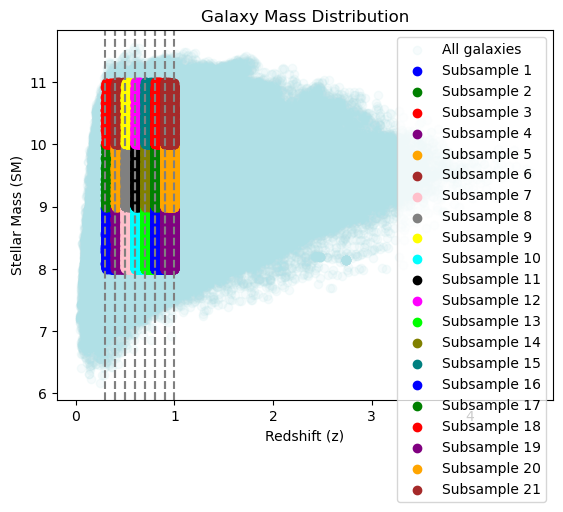

Subsample 1: N = 3118
  z_mean: 0.35
  SM_mean: 8.5
  z_min: 0.3

Subsample 2: N = 2323
  z_mean: 0.35
  SM_mean: 9.5
  z_min: 0.3

Subsample 3: N = 1212
  z_mean: 0.35
  SM_mean: 10.5
  z_min: 0.3

Subsample 4: N = 3908
  z_mean: 0.45
  SM_mean: 8.5
  z_min: 0.4

Subsample 5: N = 2512
  z_mean: 0.45
  SM_mean: 9.5
  z_min: 0.4

Subsample 6: N = 1449
  z_mean: 0.45
  SM_mean: 10.5
  z_min: 0.4

Subsample 7: N = 5024
  z_mean: 0.55
  SM_mean: 8.5
  z_min: 0.5

Subsample 8: N = 3017
  z_mean: 0.55
  SM_mean: 9.5
  z_min: 0.5

Subsample 9: N = 1548
  z_mean: 0.55
  SM_mean: 10.5
  z_min: 0.5

Subsample 10: N = 7933
  z_mean: 0.6500000000000001
  SM_mean: 8.5
  z_min: 0.6000000000000001

Subsample 11: N = 4368
  z_mean: 0.6500000000000001
  SM_mean: 9.5
  z_min: 0.6000000000000001

Subsample 12: N = 2272
  z_mean: 0.6500000000000001
  SM_mean: 10.5
  z_min: 0.6000000000000001

Subsample 13: N = 13072
  z_mean: 0.7500000000000002
  SM_mean: 8.5
  z_min: 0.7000000000000002

Subsample 14: N =

In [15]:
    
# Define z and SM ranges
z_values = np.arange(0.3, 1.1, 0.1)  ### be careful about completness issues, maybe stop at 0.4 for high SM

#SM_range = np.linspace(9.5, 11, num=2) # High SM
#SM_range = np.linspace(8, 9.5, num=2) #Low SM
SM_range = np.linspace(8, 11, num=4) # diff SM



# Create subsamples
subsamples = []
z_mean_range = []
SM_mean_range = []

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    z_mean = (z_min + z_max) / 2
    z_mean_range.append(z_mean)

    for j in range(len(SM_range) - 1):
        SM_min = SM_range[j]
        SM_max = SM_range[j + 1]
        SM_mean = (SM_min + SM_max) / 2
        SM_mean_range.append(SM_mean)

        subsample = package.subsample.Subsample(z_min, z_max, SM_min, SM_max)
        
        subsample.info['z_mean'] = z_mean  # Add z_mean to the info dictionary
        subsample.info['z_min'] = z_min 
        subsample.info['SM_mean'] = SM_mean  # Add SM_mean to the info dictionary
        subsample.info['delta_z'] = (z_max - z_min)  # Assuming delta_z is the redshift bin width
        subsamples.append(subsample)


        
        
plt.scatter(t['z'], t['SM'], label='All galaxies',color='powderblue',alpha=0.1)

#filtered_data = t[t['z'] <= 1.2]

#plt.scatter(filtered_data['z'], filtered_data['SM'], label='All galaxies', color='powderblue', alpha=0.1)




# Scatter plot with subsample colors
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'yellow', 'cyan', 'black', 'magenta', 'lime', 'olive', 'teal']
num_colors = len(colors)


for i, subsample in enumerate(subsamples):
    subset = subsample.apply(t)
    z_subsample = t['z'][subset]
    SM_subsample = t['SM'][subset]

    plt.scatter(z_subsample, SM_subsample, label=f'Subsample {i+1}', c=colors[i % num_colors])

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    plt.axvline(z_min, linestyle='--', color='gray')
    plt.axvline(z_max, linestyle='--', color='gray')

plt.xlabel('Redshift (z)')
plt.ylabel('Stellar Mass (SM)')
plt.title('Galaxy Mass Distribution')
plt.legend()
plt.show()

# Create SkyCoord catalogs for subsamples
catalogs = []

for subsample in subsamples:
    subset = subsample.apply(t)
    catalog = t[subset]
    #catalog = SkyCoord(ra=ra_subset * u.deg, dec=dec_subset * u.deg)
    
    catalogs.append(catalog)

# Print number of galaxies in each subsample
for i, subsample in enumerate(subsamples):
    N = len(catalogs[i])

    print(f"Subsample {i+1}: N = {N}")
    print(f"  z_mean: {subsample.info['z_mean']}")
    print(f"  SM_mean: {subsample.info['SM_mean']}")
    print(f"  z_min: {subsample.info['z_min']}")
    print()

## Compute the correlation functions for each subsample

In [7]:
#cfs = []

for i, catalog in enumerate(catalogs):
#for i in subsamples:

    cf = package.correlation_function.CorrelationFunction(catalog, randoms, config)
    cf.process()
    w, varw, theta, rr, dr, dd = cf.calculate_w_theta()
   
    cf.write_results(f"output_file_{i}.txt")
    cf.read_results(f"output_file_{i}.txt")
    #cf.print_num_pairs()

    #cfs.append(cf)

In [9]:

for i, catalog in enumerate(catalogs):

    subsamples[i].info['w'] = w
    subsamples[i].info['varw'] = varw
    subsamples[i].info['theta'] = theta
    subsamples[i].info['rr'] = rr
    subsamples[i].info['dd'] = dd 
    subsamples[i].info['dr'] = dr
    


In [10]:
print(subsample.info['dd'])

NNCorrelation(min_sep=0.003, max_sep=1.78, bin_size=0.1, sep_units='deg')


In [ ]:
print(counts_SN_C3[:, 5])

In [ ]:
for subsample in subsamples:
    if subsample.info['SM_mean'] == 10.5:
        print(subsample.info['rr'])



In [ ]:
def power_law(theta, A, delta):
    return A * theta**delta


def fit_and_plot_power_law(theta, w, cat):
    """
    Fits a power law to the provided 2PCF data and plots the results.

    Args:
        theta (np.ndarray): Angular separation bins.
        w (np.ndarray): 2PCF values for the current catalog.
        cat (int): Identifier for the current catalog (used for labeling).
    """

    # Fit the power law using curve_fit with initial guesses
    popt, pcov = curve_fit(power_law, subsample.info['theta'], subsample.info['w'], p0=[2e-2, -0.8], maxfev=100000)
    # Extract fitted parameters
    A_fit = popt[0]
    delta_fit = popt[1]

    # Calculate amplitude at 1 degree
    amplitude_at_1deg = power_law(1, A_fit, delta_fit)

    # Print fit parameters
    print(f"Subsample {cat}, Power-law Fit Parameters")
    print(f" Amplitude at 1°:", amplitude_at_1deg)
    print(f" Delta:", delta_fit)
    print()

    # Plot the data and fitted curve for this catalog
    plt.scatter(subsample.info['theta'], subsample.info['w'], label=f"Subsample {cat}")
    plt.plot(subsample.info['theta'], power_law(subsample.info['theta'], *popt), label='Power Law Fit')


    return amplitude_at_1deg, delta_fit


for i, subsample in enumerate(subsamples):
 
    A, delta = fit_and_plot_power_law(subsamples[i].info['theta'][i], subsamples[i].info['w'], i + 1)
    subsamples[i].info['A'] = A
    subsamples[i].info['delta'] = delta

plt.title("Power law fit")
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.yscale('log')
plt.xscale('log')
plt.savefig(os.path.join(directory_SN_C3, "r0_vs_z_for_diff_SM_SN-C3.png"))
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Select the index of the specific subsample you want to process
subsample_index = 0  # Replace 0 with the desired subsample index

# Perform the fit and power-law plot for only the selected subsample
A, delta = fit_and_plot_power_law(
    subsamples[subsample_index].info['theta'][subsample_index], 
    subsamples[subsample_index].info['w'], 
    subsample_index + 1
)

# Update the info dictionary for the selected subsample
subsamples[subsample_index].info['A'] = A
subsamples[subsample_index].info['delta'] = delta

# Plot settings
plt.title("Power law fit")
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.yscale('log')
plt.xscale('log')

plt.grid(True)
plt.legend()
plt.show()


## Compute the $r_0$ values for each subsample

In [ ]:
r0_values = []
for subsample in subsamples:
    # Create a SubsampleAnalysis object with relevant information
    analysis = package.subsample_analysis.SubsampleAnalysis(subsample.info['delta'], subsample.info['A'],
                                  subsample.info['z_mean'], subsample.info['delta_z'] ,3.68, 299792.458) # H_gamma=3.68, c=299792.458

    # Calculate R_0 for the subsample
    r0 = analysis.calculate_r0()

    r0_values.append(r0)

In [ ]:
m = np.unique(SM_mean_range) # Get the unique SM values
z= z_mean_range

print('len(m):',len(m))
print('len(z):',len(z))

zm=np.meshgrid(m,z)
np.array(zm)
zm=np.array(zm).reshape(2,-1)
zm[:,0]

r0s_reshaped = np.reshape(r0_values, (len(z), len(m))).T  # since r0s is a flattened array

In [ ]:
for i in range(len(m)):
    sigma = [0.1 * z_mean + 1 for z_mean in z]  # is the rms error on each redshift
    plt.errorbar(z, r0s_reshaped[i], yerr=sigma, label=f"SM = {m[i]:.2f}",marker='o',capsize=7,)

plt.xlabel("Redshift (z)")
plt.ylabel(r"$r_0 (h^{-1} Mpc)$")
plt.title(r"SN-C3: $r_0$ vs. Redshift (Different Stellar Mass Ranges)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(directory_SN_C3, "r0_vs_z_for_diff_SM_SN-C3.png"))

plt.show()

In [ ]:
for i, subsample in enumerate(subsamples):
    print(f"Subsample {i+1} z_mean: {subsample.info['z_mean']:.3f}")
    print(f" A: {subsample.info['A']:.3f}")
    print(f" delta: {subsample.info['delta']:.3f}")
    print()

In [ ]:

nz = hm.integrate_corr.flat_z_dist(np.min(z_values), np.max(z_values))
gg = hm.integrate_corr.AngularCF(nz,nz,p_of_z=True,zmin=np.min(z_values),zmax=np.max(z_values),z=np.mean(z_values))
gg.hod_params = {"M_min":13.27, "M_1": 14.6, "alpha":1.}
#gg.theta_min = np.min(thetas[0])*np.pi/180
#gg.theta_max = np.max(thetas[0])*np.pi/180
#gg.theta_num = len(thetas[0])

gg.theta_min = np.min(subsample.info['theta'][0])*np.pi/180
gg.theta_max = np.max(subsample.info['theta'][0])*np.pi/180

print(gg.angular_corr_gal)

In [ ]:

# wobs(theta)= b**2 * wdm(theta)
def w_model(wdm, b):
    return wdm*(b**2)

In [ ]:
sm_biases = []

for i, subsample in enumerate(subsamples):

    calculator = package.bias_calculator.BiasCalculator(w_model, gg)

    # Calculate bias and error for the subsample
    bias, bias_error, popt, pcov = calculator.calculate_bias(subsample.info['w'])

    # Print and store results
    print(f"Subsample {i+1} SM_mean: {subsample.info['SM_mean']:.3f}")
    print(f"Bias: {bias:.3f} +/- {bias_error:.3f}")
    print()

    sm_biases.append([subsample.info['SM_mean'], bias, bias_error])

In [ ]:


# Create a NumPy array from the list of lists (modified for 3 columns)
sm_biases_array = np.array(sm_biases)

# Construct the full file path
file_path = os.path.join(directory_SN_C3, "sm_biases.txt")

# Save the array using delimiter for each column (modified for 3 columns)
np.savetxt(file_path, sm_biases_array, delimiter=',', fmt='%.3f')


# Load the data from the text file
SN_C3 = np.loadtxt(file_path, delimiter=',')

# Extract SM_mean, bias, and error values from the loaded data
sm_means = SN_C3[:, 0]
sm_biases = SN_C3[:, 1]
sm_biases_errors = SN_C3[:, 2]

In [ ]:
sm_biases_reshaped = np.reshape(sm_biases, (len(z), len(m))).T  


In [ ]:

for i in range(len(m)):
    print(sm_biases_reshaped[i])

In [ ]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

for i in range(len(m)):
    plt.errorbar(z, sm_biases_reshaped[i],yerr= sm_biases_errors[i],label=f"SM = {m[i]:.2f}",marker='o',capsize=7)

plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"SN-C3: Bias vs. Redshift (Different Stellar Mass Ranges)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(directory_SN_C3, "Bias_vs_z_for_diff_SM_SN_C3.png"))

plt.show()

In [17]:
COSMOS = np.loadtxt(directory_COSMOS + '/sm_biases.txt', delimiter=',')
X3 = np.loadtxt(directory_SN_X3 + '/sm_biases.txt', delimiter=',')
E2 = np.loadtxt(directory_SN_E2 + '/sm_biases.txt', delimiter=',')
C3 = np.loadtxt(directory_SN_C3 + '/sm_biases.txt', delimiter=',')



In [18]:

COSMOS_reshaped = np.reshape(np.array(COSMOS[:, 1]), (len(z), len(m))).T  
X3_reshaped = np.reshape(np.array(X3[:, 1]), (len(z), len(m))).T  
E2_reshaped = np.reshape(np.array(E2[:, 1]), (len(z), len(m))).T  
C3_reshaped = np.reshape(np.array(C3[:, 1]), (len(z), len(m))).T  

NameError: name 'z' is not defined

In [ ]:
res = os.path.join(home_dir, 'Master_Thesis', 'Results')


In [ ]:
plt.figure(figsize=(10, 8)) 
for i in range(len(m)):
    plt.errorbar(z, sm_biases_reshaped[i],yerr= sm_biases_errors[i],label=f"SN-C3: SM = {m[i]:.2f}",marker="^", linestyle='dashed',capsize=7)
    plt.errorbar(z, COSMOS_reshaped[i],yerr=COSMOS[:, 2][i],  label=f"COSMOS: SM = {m[i]:.2f}",marker='o',capsize=7)
    plt.errorbar(z, X3_reshaped[i],yerr=X3[:, 2][i],  label=f"X3: SM = {m[i]:.2f}",marker="D",linestyle='dotted',capsize=7)
    plt.errorbar(z, E2_reshaped[i],yerr=E2[:, 2][i],  label=f"E2: SM = {m[i]:.2f}",marker="X",linestyle='dashdot',capsize=7)
    
plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"Bias vs. Redshift (Different Stellar Mass Ranges)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(res,"Bias_vs_z_for_diff_SM.png"))

plt.show()

In [ ]:
# Find the index of the minimum value in m
i_max = np.argmax(m)
plt.figure(figsize=(10, 8)) 

# Plot the graph for the minimum value of m
plt.errorbar(z, sm_biases_reshaped[i_max], yerr=sm_biases_errors[i_max], label=f"SN-C3: SM = {m[i_max]:.2f}",marker="^", linestyle='dashed',capsize=7)
plt.errorbar(z, COSMOS_reshaped[i_max], yerr=COSMOS[:, 2][i_max], label=f"COSMOS:SM = {m[i_max]:.2f}", marker='o', capsize=7)
plt.errorbar(z, X3_reshaped[i_max],yerr=X3[:, 2][i_max],  label=f"X3: SM = {m[i_max]:.2f}",marker="D",linestyle='dotted',capsize=7)
plt.errorbar(z, E2_reshaped[i_max],yerr=E2[:, 2][i_max],  label=f"E3: SM = {m[i_max]:.2f}",marker="X",linestyle='dashdot',capsize=7)


# Add labels, title, grid, and legend
plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"Bias vs Redshift (Maximum Stellar Mass)")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Create a colormap
cmap = plt.get_cmap('viridis', len(m))

plt.figure(figsize=(10, 8)) 

for i in range(len(m)):
    plt.errorbar(z, sm_biases_reshaped[i], yerr=sm_biases_errors[i], label='SN-C3',
                  marker="^", linestyle='dashed', capsize=7, color=cmap(i))
    plt.errorbar(z, COSMOS_reshaped[i], yerr=COSMOS[:, 2][i], 
                 label=f" SM = {m[i]:.2f}", marker='o', capsize=7, color=cmap(i))
    plt.errorbar(z, X3_reshaped[i],yerr=X3[:, 2][i],  label=f"X3: SM = {m[i]:.2f}",marker="D",linestyle='dotted', capsize=7, color=cmap(i))
    plt.errorbar(z, E2_reshaped[i],yerr=E2[:, 2][i],  label=f"E2: SM = {m[i]:.2f}",marker="X",linestyle='dashdot',capsize=7,color=cmap(i))



plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"Bias vs. Redshift (Different Stellar Mass Ranges)")
plt.grid(True)
plt.legend()
#plt.savefig(os.path.join(res,"Bias_vs_z_for_diff_SM.png"))

plt.show()

In [ ]:
plt.figure(figsize=(15, 10)) 


# Create shades of red and blue for the plots
num_shades = len(m)
reds = plt.cm.Reds(np.linspace(0.4, 0.8, num_shades))  # Shades of red
blues = plt.cm.Blues(np.linspace(0.4, 0.8, num_shades))  # Shades of blue
greens = plt.cm.Greens(np.linspace(0.4, 0.8, num_shades)) # Shades of green
greys= plt.cm.Grays(np.linspace(0.4, 0.8, num_shades)) # Shades of grey

plt.figure(figsize=(8, 6)) 

for i in range(len(m)):
    plt.errorbar(z, sm_biases_reshaped[i],yerr= sm_biases_errors[i],label=f"SN-C3: SM = {m[i]:.2f}",marker="^", linestyle='dashed',capsize=7,color=reds[i])
    plt.errorbar(z, COSMOS_reshaped[i],yerr=COSMOS[:, 2][i],  label=f"COSMOS: SM = {m[i]:.2f}",marker='o',capsize=7,color=blues[i])
    plt.errorbar(z, X3_reshaped[i],yerr=X3[:, 2][i],  label=f"SN-X3: SM = {m[i]:.2f}",marker="D",linestyle='dotted', capsize=7, color=greens[i])
    plt.errorbar(z, E2_reshaped[i],yerr=E2[:, 2][i],  label=f"SN-E2: SM = {m[i]:.2f}",marker="X",linestyle='dashdot',capsize=7,color=greys[i])



plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"Bias vs. Redshift (Different Stellar Mass Ranges)")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(res,"Bias_vs_z_for_diff_SM.png"))

plt.show()

In [ ]:
plt.figure(figsize=(8, 6)) 
plt.errorbar(z, sm_biases_reshaped[2],yerr= sm_biases_errors[i],label=f"SN-C3: SM = {m[i]:.2f}",marker="^", linestyle='dashed',capsize=7,color=reds[i])
plt.errorbar(z, COSMOS_reshaped[2],yerr=COSMOS[:, 2][i],  label=f"COSMOS: SM = {m[i]:.2f}",marker='o',capsize=7,color=blues[i])
plt.errorbar(z, X3_reshaped[2],yerr=X3[:, 2][i],  label=f"SN-X3: SM = {m[i]:.2f}",marker="D",linestyle='dotted', capsize=7, color=greens[i])
plt.errorbar(z, E2_reshaped[2],yerr=E2[:, 2][i],  label=f"SN-E2: SM = {m[i]:.2f}",marker="X",linestyle='dashdot',capsize=7,color=greys[i])

# Add labels, title, and grid
plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"Bias vs. Redshift (High Stellar Mass Range)")
plt.grid(True)

# Add legend and save the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(res, "Bias_vs_z_for_high_SM.png"))

plt.show()

In [ ]:
for i in range(len(m)):
    print(COSMOS_reshaped[i])

In [ ]:
print(COSMOS_reshaped[0])

In [ ]:
print(sm_biases_reshaped[0])

In [ ]:

def calculate_bias_variance(field_data):

  # Calculate the average bias
    average_bias = np.mean(field_data, axis=0)

  # Calculate the variance of the bias across the fields
    bias_variance = np.var(field_data, axis=0)

    return average_bias, bias_variance


field1_bias = sm_biases_reshaped[2]
field2_bias = COSMOS_reshaped[2]


field_data = [field1_bias,field2_bias]

avg_bias, bias_var = calculate_bias_variance(field_data)

print("Average Bias:", avg_bias)
print("Bias Variance:", bias_var)

In [ ]:
plt.scatter(z, avg_bias)
plt.title('Average Bias vs. Redshift')
plt.xlabel('Redshift')
plt.ylabel('Average Bias')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
for i, subsample in enumerate(subsamples):

    print(subsample.info['w'][2])


In [ ]:
print(len(subsample.info['rr']))
